In [1]:
import pandas as pd
import pickle
import torch
from tqdm.notebook import tqdm
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np 

def open_pickle(f):
    with open(f, 'rb') as fname:
        node_dict = pickle.load(fname)
    return node_dict

def to_pickle(node_dict, f):
    with open(f, 'wb') as fname:
        pickle.dump(node_dict, fname)

In [2]:
phekg_cui_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_cui_dict.pkl")
phekg_icd_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_icd_dict.pkl")
phekg_icd9_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_icd9_dict.pkl")
phekg_atc_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_atc_dict.pkl")
phekg_snomed_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_snomed_dict.pkl")
phekg_phecode_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_phecode_dict.pkl")
phekg_rxnorm_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_rxnorm_dict.pkl")
phekg_lnc_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_lnc_dict.pkl")
phekg_cpt_dict = open_pickle("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/benchmarks/data/phekg_cpt_dict.pkl")

phekg_all_dict = {
    'UMLS_CUI': phekg_cui_dict,
    'ICD10CM': phekg_icd_dict,
    'ICD9CM': phekg_icd9_dict,
    'SNOMEDCT_US': phekg_snomed_dict,
    'RXNORM': phekg_rxnorm_dict, 
    'ATC': phekg_atc_dict,
    'PHECODE': phekg_phecode_dict,
    'LNC': phekg_lnc_dict,
    'CPT': phekg_cpt_dict
}

In [3]:
phekg_node_df = pd.read_csv("/n/holylfs06/LABS/mzitnik_lab/Lab/ruthjohnson/kg_paper_revision/connected_node_v3_df.csv", sep='\t')
phekg_node_df['original_code'] = phekg_node_df['node_id'].str.split(':', expand=True)[0]

## Autoimmune

In [4]:
crohns_list = ["R19.7", "R50.9", "R53", "R10.84", "K92.1", "K12.39", "R63.0", "R63.6", "K60.3"]

lupus_list = ["R50.9", "R53", "M25.50", "L93.1", "L56.3", "I73.0", "R06.0", "I20.8", "H04.12", "G44", "R41.9"]

graves_list = ["R00.2", "R63.6", "R53", "R19.8", "N92.6", "E04.9", "N52.8", "R68.89", "H05.25", "R41.0", "R41.82", "T67.9"]

ms_list = ["M54.1", "G83", "R42", "R53", "H53", "R27", "N53", "R47.8", "H53.3", "N39.41", "F98.1", "R41.82", "G57", "R41.9", "K58", "M62.81"]
#["G57", 'R53',  "R41.0", "H54.10", "H53",  "R42", "N53",  "N39.41", "R41.82", "R47.8", "M54.1", "K58", "H53.3", "R15", "F98.1", "R27", "R26.9"]

disease_list = [("Grave's", 'E05.0', graves_list), ("Lupus", 'M32.9', lupus_list), ("MS", 'G35', ms_list), ("Crohns", 'K50.00', crohns_list)]

In [ ]:
icd_names = ['No symptoms', 'Skin sensation', 
             'Abnormality of gait', 
             'Peripheral vertigo',
       'Fatigue', 'Visual disturbances',
       'Lack of coordination', 'Impotence',
       'Speech disturbance', 'Diplopia',
       'Disorders of bladder', 'Optic neuritis',
       'Episodic mood disorder',
       'Mononeuritis of lower limb',
       'Cognition symptoms',
       'Disorders of intestine']



In [20]:
for code in ms_list:
    print(phekg_node_df.loc[(phekg_node_df['ntype']=='ICD10CM') & (phekg_node_df['original_code']==code)][['original_code', 'node_name']].values)

[['M54.1' 'Radiculitis NOS']]
[['G83' 'Other paralytic syndromes']]
[['R42' 'Vertigo NOS']]
[['R53' 'Malaise and fatigue']]
[['H53' 'Visual disturbances']]
[['R27' 'Other lack of coordination']]
[['N53' 'Other male sexual dysfunction']]
[['R47.8' 'Other speech disturbances']]
[['H53.3' 'Other and unspecified disorders of binocular vision']]
[['N39.41' 'Urge incontinence']]
[['F98.1' 'Functional encopresis']]
[['R41.82' 'Change in mental status NOS']]
[['G57' 'Mononeuropathies of lower limb']]
[['R41.9'
  'Unspecified symptoms and signs involving cognitive functions and awareness']]
[['K58' 'Irritable bowel syndrome']]
[['M62.81' 'Muscle weakness (generalized)']]


In [31]:
disease_df_list = []

for tup in disease_list:
    disease_name = tup[0]
    icd_list = tup[2]

    icd_df = pd.DataFrame({'icd': icd_list})
    
    for compare_tup in disease_list:
        disease_compare_name = compare_tup[0]
        disease_ind = compare_tup[1]
        
        running_h = np.zeros((1, 128))
        disease_h = phekg_icd_dict[disease_ind]
        cos_list = []
        ind_list = []
        i = 0
        for code in icd_df['icd'].tolist():
            running_h = running_h + phekg_icd_dict[code]
            c = cosine_similarity([disease_h], running_h)
            cos_list.append(c[0][0])
            i += 1
            ind_list.append(i)

        icd_df['cos'] = cos_list
        icd_df['disease'] = disease_name
        icd_df['compare_disease'] = disease_compare_name
        icd_df['ind'] = ind_list
        
        disease_df_list.append(icd_df.copy())

all_disease_df = pd.concat(disease_df_list)

zero_df = pd.DataFrame({'disease': ["Grave's"]*4, 'compare_disease':["Grave's", "MS", "Crohns", "Lupus"], 'ind':[0]*4, 'cos':[0]*4})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["MS"]*4, 'compare_disease':["Grave's", "MS", "Crohns", "Lupus"], 'ind':[0]*4, 'cos':[0]*4})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["Lupus"]*4, 'compare_disease':["Grave's", "MS", "Crohns", "Lupus"], 'ind':[0]*4, 'cos':[0]*4})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["Crohns"]*4, 'compare_disease':["Grave's", "MS", "Crohns", "Lupus"], 'ind':[0]*4, 'cos':[0]*4})
all_disease_df = pd.concat([zero_df, all_disease_df])

Text(0, 0.5, 'Cosine similarity')

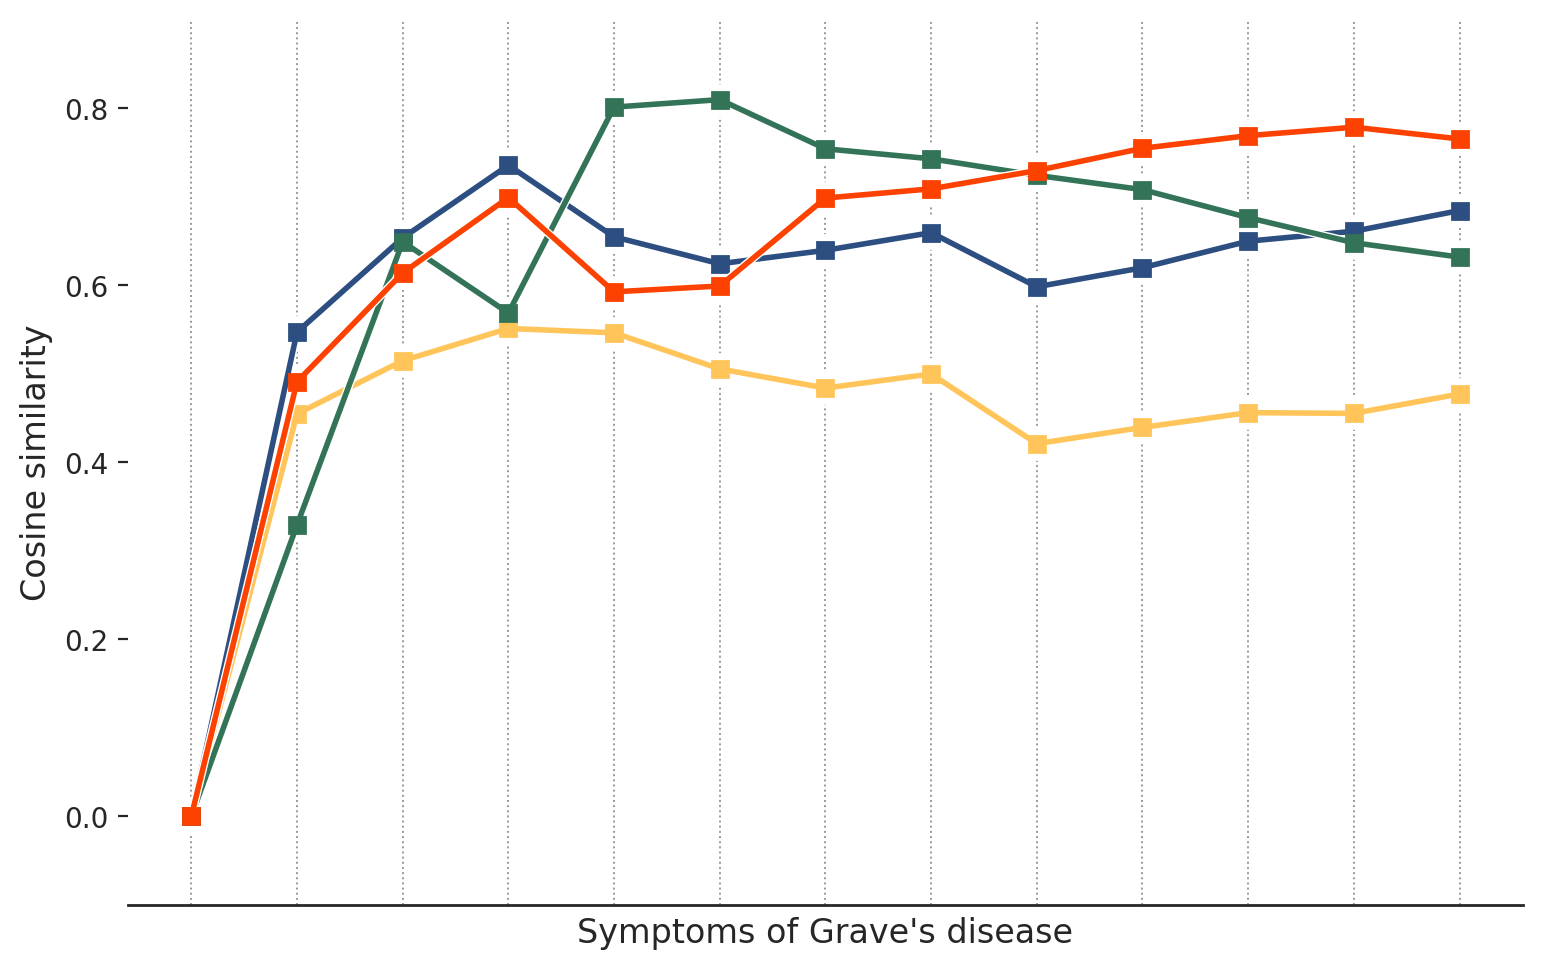

In [41]:
import matplotlib 
pal = ['#FFC55A', '#2C4E80', '#337357', '#FC4100']

fig, ax_count = plt.subplots(figsize=(9, 5.75))
matplotlib.rcParams['axes.linewidth'] = 1

for i in range(-1, 12):
    ax_count.axvline(x=i, color='gray', alpha=0.8, linewidth=0.7, linestyle=':', zorder=0)

disease_name="Grave's"
compare_disease_list =  ["Lupus", "MS", "Crohns", "Grave's"]
for i in range(0, len(compare_disease_list)):
    compare_disease = compare_disease_list[i]

    ax_count.plot(all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['ind']-1,
          all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['cos'],
          color='white', linewidth=3) 
    
    ax_count.plot(all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['ind']-1,
              all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['cos'],
              color=pal[i], linestyle='-', marker='s', linewidth=2) 
    
    ax_count.scatter(all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['ind']-1,
              all_disease_df.loc[(all_disease_df['disease'] == disease_name) & (all_disease_df['compare_disease']==compare_disease)]['cos'],
              color="black", marker='s', linewidth=6, edgecolor='white')

ax_count.set_ylim(-0.1, 0.9)

new_labels = ['Palpitations', 'Weight loss', 'Fatigue', "Digestive\n  symptoms", "Irregular\n  menstruation", 'Goiter', 'Impotence',
              'Integumentary tissue\n or skin symptoms', 'Exophthalmos', 'Nervousness', 'Irritability', 'Heat\nsensitivity']

for i in range(0, len(new_labels)):
    if i%2 == 0:
        side = 1
        bias = 0.04
    else:
        side = 1
        bias = -0.22

sns.despine(top=True, right=True, left=True, bottom=True)

ax_count.set_xticks([])

sns.despine(top=True, right=True, bottom=False, left=True, ax=ax_count)
ax_count.tick_params(axis='x', which=u'both', length=0)
plt.xlabel("Symptoms of Grave's disease", fontsize=12)
plt.ylabel("Cosine similarity", fontsize=12)

In [42]:
fig.savefig("revision_embed_arith_big_fig.svg", dpi=300)

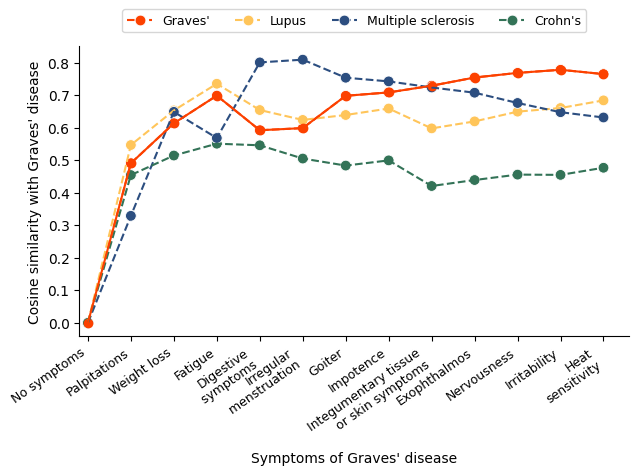

In [123]:
icd_names = ['No symptoms', 'Palpitations', 'Weight loss', 'Fatigue', "Digestive\n  symptoms", "Irregular\n  menstruation", 'Goiter', 'Impotence',
              'Integumentary tissue\n or skin symptoms', 'Exophthalmos', 'Nervousness', 'Irritability', 'Heat\nsensitivity']

pal = ['#FC4100', '#FFC55A', '#2C4E80', '#337357']

fig, ax = plt.subplots(figsize=(6.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == "Grave's"], x='ind', y='cos', 
             hue='compare_disease', linestyle='--', palette=pal, ax=ax)

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == "Grave's") & 
                                     (all_disease_df['compare_disease'] == "Grave's")], 
                                     x='ind', y='cos', color=pal[0], ax=ax)

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == "Grave's"], x='ind', y='cos', 
                hue='compare_disease', s=60, palette=pal, ax=ax)

ax.scatter(x=all_disease_df.loc[(all_disease_df['disease'] == "Grave's") & 
                                     (all_disease_df['compare_disease'] == "Grave's")]['ind'],
                                     y=all_disease_df.loc[(all_disease_df['disease'] == "Grave's") & 
                                     (all_disease_df['compare_disease'] == "Grave's")]['cos'], color=pal[0])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right', fontsize=9)
ax.tick_params(axis='x', labelrotation=35)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[4]),
    (handler[1],handler[5]),
     (handler[2],handler[6]),
     (handler[3],handler[7])]
lab = ["Graves'",'Lupus', 'Multiple sclerosis', "Crohn's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.15), 
          ncol=4, fontsize=9)

ax.set_xlim(-0.2)
#ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity with Graves' disease")
ax.set_xlabel("Symptoms of Graves' disease")

sns.despine(right=True, top=True)

plt.tight_layout()

/tmp/ipykernel_861333/2162326931.py:65: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


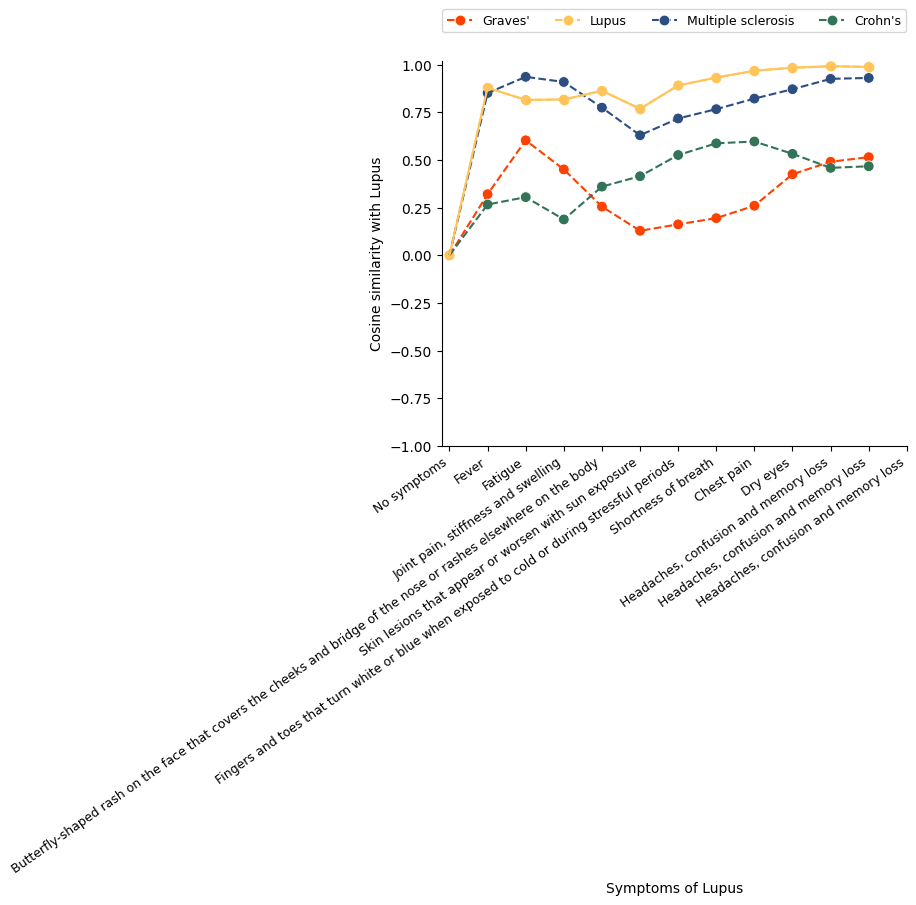

In [125]:
disease_name = "Lupus"
icd_list = list(lupus_list)

icd_names = ["No symptoms", 'Headache', 'Pain in joint', 'Chest pain',
       'Fever',
       'Fatigue', "Raynaud's syndrome", 'Shortness of breath',
       'Tear film insufficiency', 'Memory loss']
icd_names = [
    "No symptoms",
    "Fever",
    "Fatigue",
    "Joint pain, stiffness and swelling",
    "Butterfly-shaped rash on the face that covers the cheeks and bridge of the nose or rashes elsewhere on the body",
    "Skin lesions that appear or worsen with sun exposure",
    "Fingers and toes that turn white or blue when exposed to cold or during stressful periods",
    "Shortness of breath",
    "Chest pain",
    "Dry eyes",
    "Headaches, confusion and memory loss",
    "Headaches, confusion and memory loss",
    "Headaches, confusion and memory loss"
]

pal = ['#FC4100', '#FFC55A', '#2C4E80', '#337357']

fig, ax = plt.subplots(figsize=(6, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', linestyle='--', palette=pal, ax=ax,
             hue_order=["Grave's", "Lupus", "MS", "Crohns"])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)], 
                                     x='ind', y='cos', color=pal[1], ax=ax)

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=60, palette=pal, ax=ax,
                hue_order=["Grave's", "Lupus", "MS", "Crohns"])

ax.scatter(x=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['ind'],
                                     y=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['cos'], color=pal[1])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right', fontsize=9)
ax.tick_params(axis='x', labelrotation=35)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[4]),
    (handler[1],handler[5]),
     (handler[2],handler[6]),
     (handler[3],handler[7])]

lab = ["Graves'",'Lupus', 'Multiple sclerosis', "Crohn's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.15), 
          ncol=4, fontsize=9)

ax.set_xlim(-0.2)
ax.set_ylim(-1, 1.02)
ax.set_ylabel("Cosine similarity with Lupus")
ax.set_xlabel("Symptoms of Lupus")

sns.despine(right=True, top=True)

plt.tight_layout()

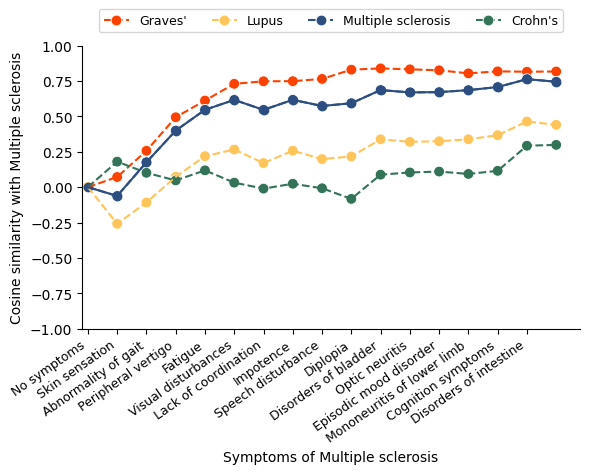

In [301]:
disease_name = "MS"
icd_list = list(ms_list)

icd_names = ['No symptoms', 'Skin sensation', 'Abnormality of gait', 'Peripheral vertigo',
       'Fatigue', 'Visual disturbances',
       'Lack of coordination', 'Impotence',
       'Speech disturbance', 'Diplopia',
       'Disorders of bladder', 'Optic neuritis',
       'Episodic mood disorder',
       'Mononeuritis of lower limb',
       'Cognition symptoms',
       'Disorders of intestine']

pal = ['#FC4100', '#FFC55A', '#2C4E80', '#337357']

fig, ax = plt.subplots(figsize=(6, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', linestyle='--', palette=pal, ax=ax,
             hue_order=["Grave's", "Lupus", "MS", "Crohns"])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)], 
                                     x='ind', y='cos', color=pal[2], ax=ax)

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=60, palette=pal, ax=ax,
                hue_order=["Grave's", "Lupus", "MS", "Crohns"])

ax.scatter(x=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['ind'],
                                     y=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['cos'], color=pal[2])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right', fontsize=9)
ax.tick_params(axis='x', labelrotation=35)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[4]),
    (handler[1],handler[5]),
     (handler[2],handler[6]),
     (handler[3],handler[7])]

lab = ["Graves'",'Lupus', 'Multiple sclerosis', "Crohn's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.15), 
          ncol=4, fontsize=9)

ax.set_xlim(-0.2)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity with Multiple sclerosis")
ax.set_xlabel("Symptoms of Multiple sclerosis")

sns.despine(right=True, top=True)

plt.tight_layout()

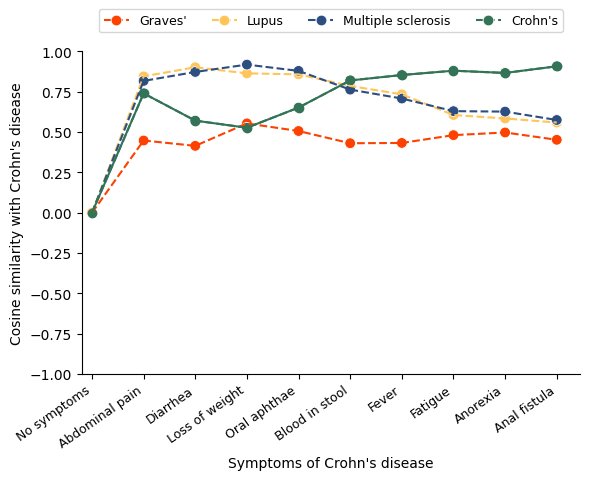

In [135]:
disease_name = "Crohns"
icd_list = list(crohns_list)

icd_names = ['No symptoms', 'Abdominal pain', 'Diarrhea',
       'Loss of weight', 'Oral aphthae',
       'Blood in stool',
       'Fever',
       'Fatigue', 'Anorexia', 'Anal fistula']

pal = ['#FC4100', '#FFC55A', '#2C4E80', '#337357']

fig, ax = plt.subplots(figsize=(6, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', linestyle='--', palette=pal, ax=ax,
             hue_order=["Grave's", "Lupus", "MS", "Crohns"])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)], 
                                     x='ind', y='cos', color=pal[3], ax=ax)

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=60, palette=pal, ax=ax,
                hue_order=["Grave's", "Lupus", "MS", "Crohns"])

ax.scatter(x=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['ind'],
                                     y=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                                     (all_disease_df['compare_disease'] == disease_name)]['cos'], color=pal[3])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right', fontsize=9)
ax.tick_params(axis='x', labelrotation=35)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[4]),
    (handler[1],handler[5]),
     (handler[2],handler[6]),
     (handler[3],handler[7])]

lab = ["Graves'",'Lupus', 'Multiple sclerosis', "Crohn's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.15), 
          ncol=4, fontsize=9)

ax.set_xlim(-0.2)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity with Crohn's disease")
ax.set_xlabel("Symptoms of Crohn's disease")

sns.despine(right=True, top=True)

plt.tight_layout()

In [5]:
heart_disease_list = ["M25.60","I20.8", "R07.1",  "G57"]
stroke_list = ["G44.89","G57","R27.8", "G83.8","R47.02",  "H53.13"]
copd_list = ["R06.0", "R06.2", "R07.8", "R05", "J06.9", "R53", "R63.6", "R60.1"]
lung_cancer_list = ["R05", "R07.8", "R04.2",  "R06.0","R49.0", "R06.2"]
dementia_list = [ "F51.8","F32","R41.3","F22","R41.9","F06.30","R41.840"]

disease_list = [("Heart disease", 'I11', heart_disease_list),
               ("Stroke", "I63", stroke_list),
               ("COPD", "J44.0", copd_list),
               ("Lung cancer", "C34.90", lung_cancer_list),
               ("Dementia", "F03", dementia_list)]

In [281]:
'R26.81' in phekg_icd_dict

True

In [290]:
disease_df_list = []

for tup in disease_list:
    disease_name = tup[0]
    icd_list = tup[2]

    icd_df = pd.DataFrame({'icd': icd_list})
    
    for compare_tup in disease_list:
        disease_compare_name = compare_tup[0]
        disease_ind = compare_tup[1]
        
        running_h = np.zeros((1, 128))
        disease_h = phekg_icd_dict[disease_ind]
        cos_list = []
        ind_list = []
        i = 0
        for code in icd_df['icd'].tolist():
            running_h = running_h + phekg_icd_dict[code]
            c = cosine_similarity([disease_h], running_h)
            cos_list.append(c[0][0])
            i += 1
            ind_list.append(i)

        icd_df['cos'] = cos_list
        icd_df['disease'] = disease_name
        icd_df['compare_disease'] = disease_compare_name
        icd_df['ind'] = ind_list
        
        disease_df_list.append(icd_df.copy())

all_disease_df = pd.concat(disease_df_list)

zero_df = pd.DataFrame({'disease': ["Heart disease"]*5, 
                        'compare_disease':["Heart disease", "Stroke", "COPD", "Lung cancer", "Dementia"],
                        'ind':[0]*5 ,'cos':[0]*5})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["Stroke"]*5, 'compare_disease':["Heart disease", "Stroke", "COPD", "Lung cancer", "Dementia"], 'ind':[0]*5, 'cos':[0]*5})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["COPD"]*5, 'compare_disease':["Heart disease", "Stroke", "COPD", "Lung cancer", "Dementia"], 'ind':[0]*5, 'cos':[0]*5})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["Lung cancer"]*5, 'compare_disease':["Heart disease", "Stroke", "COPD", "Lung cancer", "Dementia"], 'ind':[0]*5, 'cos':[0]*5})
all_disease_df = pd.concat([zero_df, all_disease_df])

zero_df = pd.DataFrame({'disease': ["Dementia"]*5, 'compare_disease':["Heart disease", "Stroke", "COPD", "Lung cancer", "Dementia"], 'ind':[0]*5, 'cos':[0]*5})
all_disease_df = pd.concat([zero_df, all_disease_df])

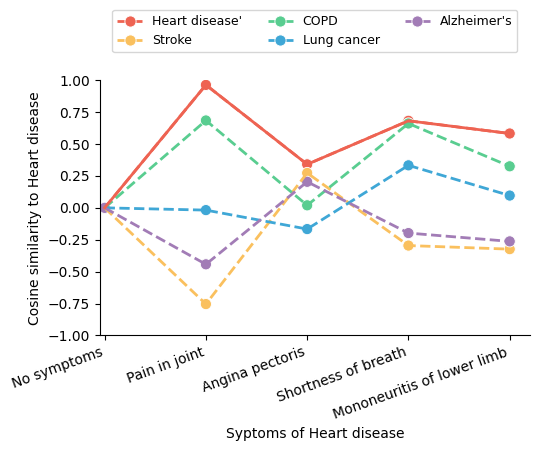

In [267]:
icd_list = list(heart_disease_list)
disease_name="Heart disease"
disease_title="Heart disease"

icd_names = ['No symptoms', 'Pain in joint', 'Angina pectoris',
       'Shortness of breath', 'Mononeuritis of lower limb']

pal = ['#EE6352', '#FAC05E', '#59CD90', '#3FA7D6', '#A27CB6']

fig, ax = plt.subplots(figsize=(5.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', palette=pal, ax=ax, lw=2, linestyle='--')

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=65, palette=pal, ax=ax)

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)], x='ind', y='cos', 
                color=pal[0], ax=ax, lw=2)

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right')
ax.tick_params(axis='x', labelrotation=20)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[5]),
    (handler[1],handler[6]),
     (handler[2],handler[7]),
     (handler[3],handler[8]),
     (handler[4],handler[9])]

lab = ["Heart disease'",'Stroke', 'COPD', 'Lung cancer', "Alzheimer's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.3), 
          ncol=3, fontsize=9)

ax.set_xlim(-0.05)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity to Heart disease")
ax.set_xlabel("Syptoms of Heart disease")

sns.despine(right=True, top=True)

plt.tight_layout()

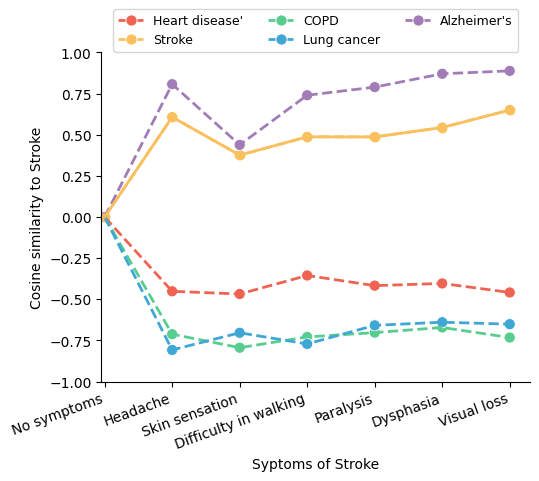

In [291]:
icd_list = list(stroke_list)
disease_name="Stroke"

icd_names = ['No symptoms', 'Headache', 'Skin sensation',
       'Difficulty in walking', 'Paralysis',
       'Dysphasia',
       'Visual loss']

pal = ['#EE6352', '#FAC05E', '#59CD90', '#3FA7D6', '#A27CB6']

fig, ax = plt.subplots(figsize=(5.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', palette=pal, ax=ax, lw=2, linestyle='--', hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=65, palette=pal, ax=ax, hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)], x='ind', y='cos', 
                color=pal[1], ax=ax, lw=2)

df = all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)]

ax.scatter(x=df['ind'], y=df['cos'], 
                color=pal[1])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right')
ax.tick_params(axis='x', labelrotation=20)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[5]),
    (handler[1],handler[6]),
     (handler[2],handler[7]),
     (handler[3],handler[8]),
     (handler[4],handler[9])]

lab = ["Heart disease'",'Stroke', 'COPD', 'Lung cancer', "Alzheimer's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.15), 
          ncol=3, fontsize=9)

ax.set_xlim(-0.05)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity to Stroke")
ax.set_xlabel("Syptoms of Stroke")

sns.despine(right=True, top=True)

plt.tight_layout()

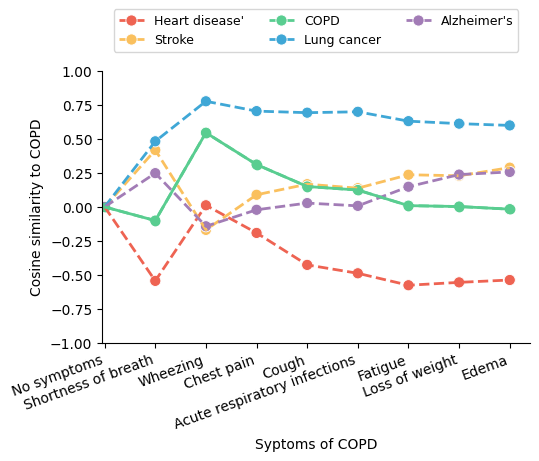

In [243]:
icd_list = list(copd_list)
disease_name="COPD"

icd_names = ['No symptoms', 'Shortness of breath', 'Wheezing', 'Chest pain', 'Cough',
       'Acute respiratory infections',
       'Fatigue', 'Loss of weight',
       'Edema']

pal = ['#EE6352', '#FAC05E', '#59CD90', '#3FA7D6', '#A27CB6']

fig, ax = plt.subplots(figsize=(5.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', palette=pal, ax=ax, lw=2, linestyle='--', hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=65, palette=pal, ax=ax, hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)], x='ind', y='cos', 
                color=pal[2], ax=ax, lw=2)

df = all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)]

ax.scatter(x=df['ind'], y=df['cos'], 
                color=pal[2])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right')
ax.tick_params(axis='x', labelrotation=20)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[5]),
    (handler[1],handler[6]),
     (handler[2],handler[7]),
     (handler[3],handler[8]),
     (handler[4],handler[9])]

lab = ["Heart disease'",'Stroke', 'COPD', 'Lung cancer', "Alzheimer's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.25), 
          ncol=3, fontsize=9)

ax.set_xlim(-0.05)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity to COPD")
ax.set_xlabel("Syptoms of COPD")

sns.despine(right=True, top=True)

plt.tight_layout()

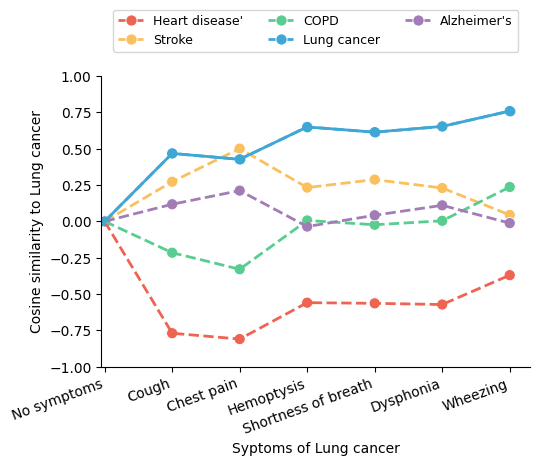

In [244]:
icd_list = list(lung_cancer_list)
disease_name="Lung cancer"

icd_names = ['No symptoms', 'Cough', 'Chest pain', 'Hemoptysis', 'Shortness of breath',
       'Dysphonia', 'Wheezing']

pal = ['#EE6352', '#FAC05E', '#59CD90', '#3FA7D6', '#A27CB6']

fig, ax = plt.subplots(figsize=(5.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', palette=pal, ax=ax, lw=2, linestyle='--', hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=65, palette=pal, ax=ax, hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)], x='ind', y='cos', 
                color=pal[3], ax=ax, lw=2)

df = all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)]

ax.scatter(x=df['ind'], y=df['cos'], 
                color=pal[3])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right')
ax.tick_params(axis='x', labelrotation=20)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[5]),
    (handler[1],handler[6]),
     (handler[2],handler[7]),
     (handler[3],handler[8]),
     (handler[4],handler[9])]

lab = ["Heart disease'",'Stroke', 'COPD', 'Lung cancer', "Alzheimer's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.25), 
          ncol=3, fontsize=9)

ax.set_xlim(-0.05)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity to Lung cancer")
ax.set_xlabel("Syptoms of Lung cancer")

sns.despine(right=True, top=True)

plt.tight_layout()

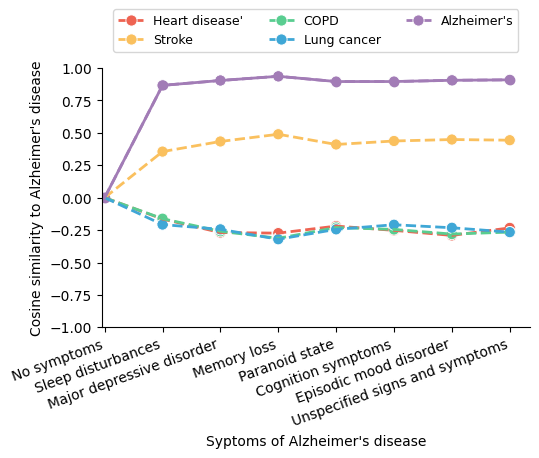

In [245]:
icd_list = list(dementia_list)
disease_name="Dementia"

icd_names = ['No symptoms', 'Sleep disturbances', 'Major depressive disorder',
       'Memory loss', 'Paranoid state',
       'Cognition symptoms',
       'Episodic mood disorder',
       'Unspecified signs and symptoms']

pal = ['#EE6352', '#FAC05E', '#59CD90', '#3FA7D6', '#A27CB6']

fig, ax = plt.subplots(figsize=(5.5, 5))

sns.lineplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
             hue='compare_disease', palette=pal, ax=ax, lw=2, linestyle='--', hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.scatterplot(data=all_disease_df.loc[all_disease_df['disease'] == disease_name], x='ind', y='cos', 
                hue='compare_disease', s=65, palette=pal, ax=ax, hue_order=['Heart disease', 'Stroke',
                                                                                         'COPD', 'Lung cancer', 'Dementia'])

sns.lineplot(data=all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)], x='ind', y='cos', 
                color=pal[4], ax=ax, lw=2)

df = all_disease_df.loc[(all_disease_df['disease'] == disease_name) & 
                (all_disease_df['compare_disease'] == disease_name)]

ax.scatter(x=df['ind'], y=df['cos'], 
                color=pal[4])

ax.set_xticks(range(0, len(icd_names)), icd_names, ha='right')
ax.tick_params(axis='x', labelrotation=20)

handler, labeler = ax.get_legend_handles_labels()
hd = [(handler[0],handler[5]),
    (handler[1],handler[6]),
     (handler[2],handler[7]),
     (handler[3],handler[8]),
     (handler[4],handler[9])]

lab = ["Heart disease'",'Stroke', 'COPD', 'Lung cancer', "Alzheimer's"]
ax.legend(hd, lab, loc="upper center", bbox_to_anchor=(0.5, 1.25), 
          ncol=3, fontsize=9)

ax.set_xlim(-0.05)
ax.set_ylim(-1, 1)
ax.set_ylabel("Cosine similarity to Alzheimer's disease")
ax.set_xlabel("Syptoms of Alzheimer's disease")

sns.despine(right=True, top=True)

plt.tight_layout()

In [6]:
disease_list = [("Graves'", 'E05.0', graves_list), ("Lupus", 'M32.9', lupus_list), ("MS", 'G35', ms_list), ("Crohn's", 'K50.00', crohns_list)] + [("Heart disease", 'I11', heart_disease_list),
               ("Stroke", "I63", stroke_list),
               ("COPD", "J44.0", copd_list),
               ("Lung cancer", "C34.90", lung_cancer_list),
               ("Dementia", "F03", dementia_list)]

In [7]:
disease_df_list = []

for tup in disease_list:
    disease_name = tup[0]
    print(disease_name)
    icd_list = tup[2]

    icd_df = pd.DataFrame({'icd': icd_list})
    
    last_icd = icd_df['icd'].values[-1]
    
    for compare_tup in disease_list:
        disease_compare_name = compare_tup[0]
        disease_ind = compare_tup[1]
        
        running_h = np.zeros((1, 128))
        disease_h = phekg_icd_dict[disease_ind]
        cos_list = []
        ind_list = []
        i = 0
        for code in icd_list:
            running_h = running_h + phekg_icd_dict[code]

            if code == last_icd:
                c = cosine_similarity([disease_h], running_h)
                cos_list.append(c.item())
                i += 1
                ind_list.append(i)
        
        #icd_df['cos'] = cos_list
        #icd_df['disease'] = disease_name
        #icd_df['compare_disease'] = disease_compare_name
        #icd_df['ind'] = ind_list
        df = pd.DataFrame({'cos': cos_list, 'disease': [disease_name], 
                           'compare_disease': [disease_compare_name]})
        
        disease_df_list.append(df)
        #print(icd_df)

all_disease_df = pd.concat(disease_df_list)

Graves'
Lupus
MS
Crohn's
Heart disease
Stroke
COPD
Lung cancer
Dementia


In [10]:
all_disease_df

,cos,disease,compare_disease
0,0.764987,Grave's,Grave's
0,0.476981,Grave's,Lupus
0,0.684124,Grave's,MS
0,0.631553,Grave's,Crohns
0,-0.401994,Grave's,Heart disease
...,...,...,...
0,-0.232984,Dementia,Heart disease
0,0.443289,Dementia,Stroke
0,-0.265448,Dementia,COPD
0,-0.265713,Dementia,Lung cancer


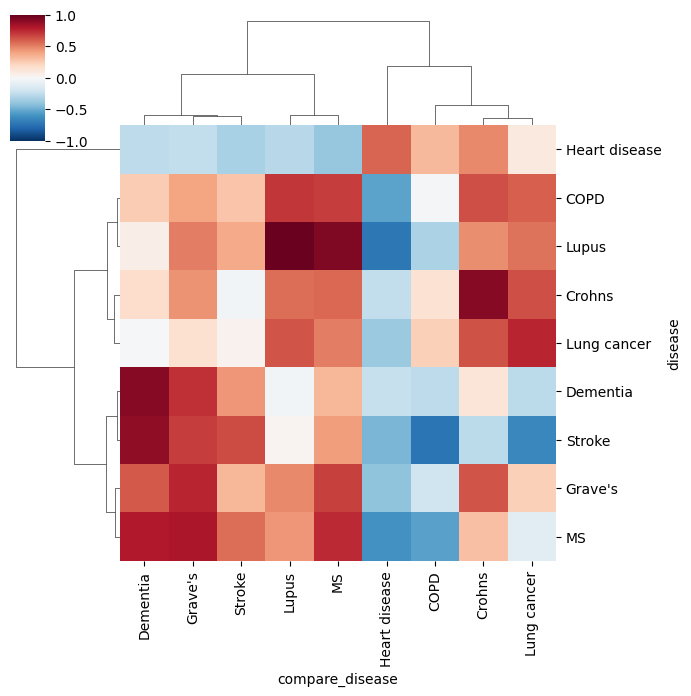

In [11]:
plot_df = all_disease_df.pivot(index='disease', columns='compare_disease', values='cos')

fig = sns.clustermap(plot_df, cmap='RdBu_r', vmin=-1, vmax=1, figsize=(7,7), 
               metric='correlation', method='average') # RdBu_r

In [8]:
all_disease_df['x'] = 0
all_disease_df['y'] = 0
i = 0.0

all_disease_df['abs_cos'] = all_disease_df['cos'].abs()

for d in all_disease_df['disease'].unique():
    all_disease_df.loc[all_disease_df['disease']==d, 'x'] = 0.5 + i
    all_disease_df.loc[all_disease_df['compare_disease']==d, 'y'] = 0.5 + 8-i
    i+=1.0

/tmp/ipykernel_1580805/3735263357.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_disease_df.loc[all_disease_df['disease']==d, 'x'] = 0.5 + i
/tmp/ipykernel_1580805/3735263357.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '8.5' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  all_disease_df.loc[all_disease_df['compare_disease']==d, 'y'] = 0.5 + 8-i


In [113]:
all_disease_df.sort_values(by='x')['compare_disease'].unique()

array(["Grave's", 'Lupus', 'MS', 'Crohns', 'Heart disease', 'Stroke',
       'COPD', 'Lung cancer', 'Dementia'], dtype=object)

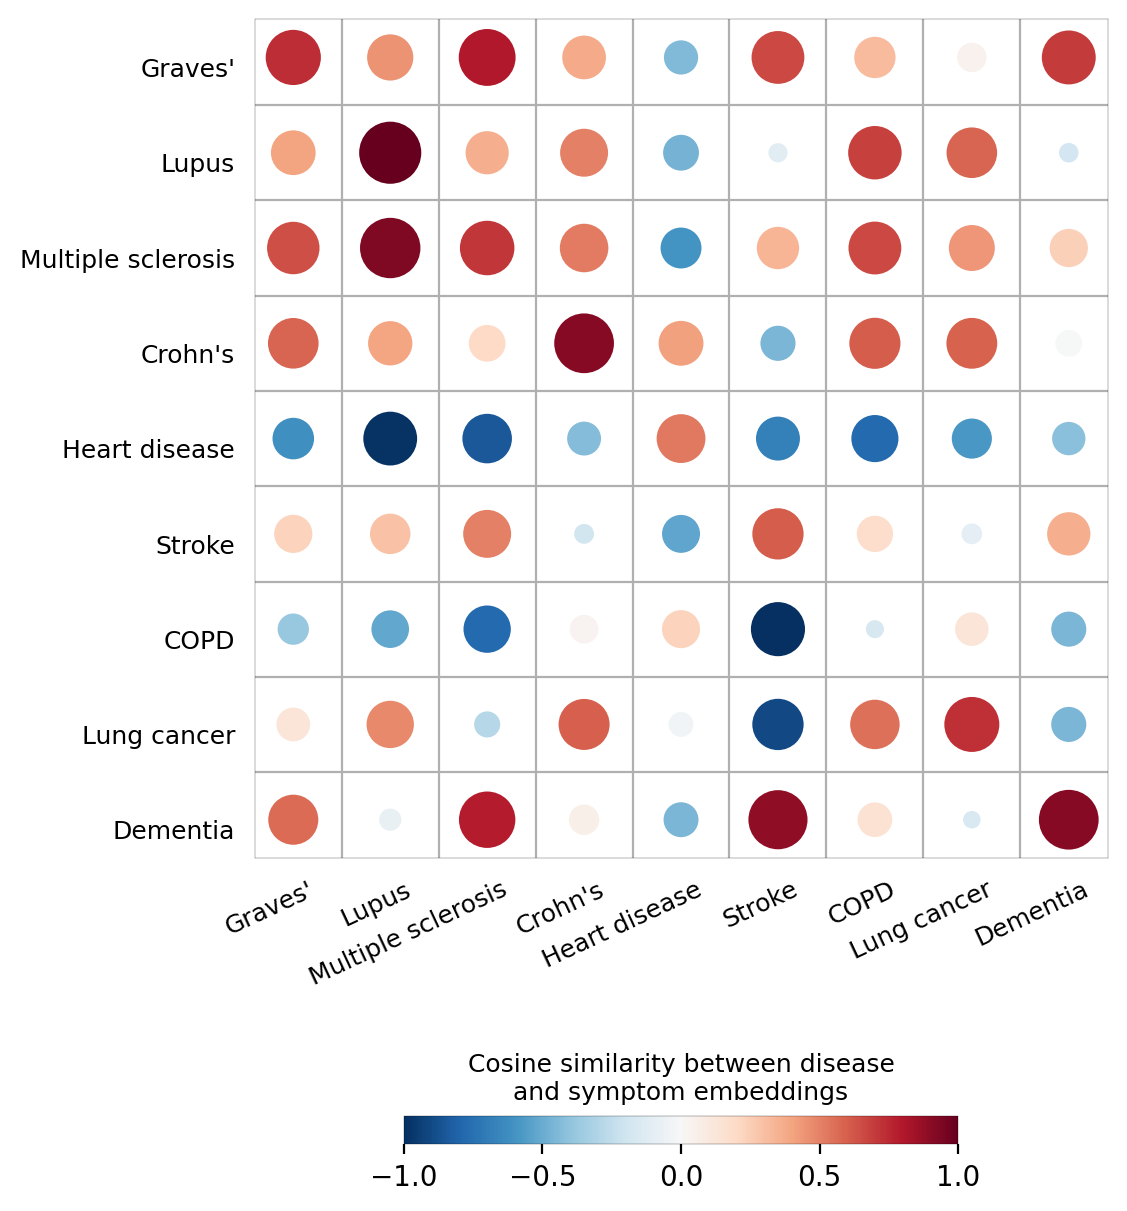

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

mpl.rcParams['axes.linewidth'] = 0.1

fig, ax = plt.subplots(figsize=(5.75, 6.75))

labels = all_disease_df['disease'].unique()

from matplotlib.ticker import MultipleLocator, AutoMinorLocator

#sns.set_style("ticks")
ax = sns.scatterplot(data=all_disease_df.sort_values(by='compare_disease'), y='y', x='x', hue='cos', 
                size='abs_cos', palette='RdBu_r', sizes=(40, 500), legend=False, ax=ax, marker='o',
               edgecolor='black', lw=0.0)

norm = plt.Normalize(-1, 1)
sm = plt.cm.ScalarMappable(cmap="RdBu_r", norm=norm)

cbar = ax.figure.colorbar(sm, ax=ax, shrink=0.65, orientation = 'horizontal', pad=0.2)
cbar.set_ticks([-1, -0.5, 0, 0.5, 1])
#cbar.set_ticklabels(['Low', 'Medium', 'High'])
cbar.ax.set_title('Cosine similarity between disease\nand symptom embeddings', fontsize=9)

#ax.grid(True, 'major')
#ax.grid(True, 'minor')
# Set the spacing of the major gridlines
ax.xaxis.set_major_locator(MultipleLocator(1))
ax.yaxis.set_major_locator(MultipleLocator(1))

# Add minor gridlines
#ax.xaxis.set_minor_locator(AutoMinorLocator(2))
#ax.yaxis.set_minor_locator(AutoMinorLocator(5))

# Enable the grid
ax.grid(which='major', linestyle='-')
#ax.grid(which='minor', linestyle=':')

plt.yticks(rotation=0, va='bottom')
plt.tick_params(bottom=False, left=False)

#ax.set_xticks([0.5, 1, 2, 3, 4, 5, 6, 7, 8])
#ax.set_yticklabels(['Lupus', 'Heart\ndisease', 'MS', 'Stroke', 'COPD', 'Lung\ncancer',
#       'Crohns', 'Dementia', "Grave's"])
#plt.yticks(rotation=0, va='top', fontsize=10)
ax.set_xticklabels([])
ax.set_yticklabels([])

label_list = ["Graves'", 'Lupus', 'Multiple sclerosis', "Crohn's", 'Heart disease', 'Stroke',
       'COPD', 'Lung cancer', 'Dementia']
for i in range(0, len(label_list)):
    text = ax.text(0.75+(1*i), -0.10, label_list[i], rotation=25, ha="right", va="top", fontsize=9)
    text = ax.text(-0.10, 0.5+(1*i), label_list[::-1][i], rotation=0, ha="right", va="top", fontsize=9)

#text = ax.text(1.5, -0.15, "Heart disease", rotation=45, ha="right", va="top", fontsize=9)

#plt.xlabel("Disease embeddings", fontsize=12)
plt.xlabel("", fontsize=12)
plt.ylabel("", fontsize=12)

#plt.ylabel("Aggregated disease symptom embeddings", fontsize=12)
#plt.title("Cosine similarity between diseases\n and aggregated symptoms", fontsize=12)

plt.subplots_adjust(left=0.05)

plt.tight_layout()
fig.savefig("comp_heatmap.svg", dpi=300)

In [323]:
plot_df

compare_disease,COPD,Crohns,Dementia,Grave's,Heart disease,Lung cancer,Lupus,MS,Stroke
disease,,,,,,,,,
COPD,-0.016461,0.645876,0.257376,0.397178,-0.537587,0.599667,0.713209,0.694731,0.288997
Crohns,0.154125,0.908294,0.180970,0.452510,-0.243083,0.643044,0.559525,0.575261,-0.034905
Dementia,-0.265448,0.125542,0.908721,0.726723,-0.232984,-0.265713,-0.031717,0.330157,0.443289
Grave's,-0.197032,0.631553,0.616008,0.764987,-0.401994,0.241574,0.476981,0.684124,0.328132
Heart disease,0.325577,0.480546,-0.262855,-0.249411,0.582675,0.096237,-0.280429,-0.387543,-0.323747
Lung cancer,0.236729,0.637946,-0.011804,0.163984,-0.369768,0.758960,0.630790,0.508355,0.044616
Lupus,-0.316469,0.466928,0.063785,0.514562,-0.723242,0.543772,0.988266,0.930278,0.377244
MS,-0.542964,0.298192,0.802567,0.816423,-0.601835,-0.114188,0.440137,0.744128,0.559653
Stroke,-0.732284,-0.266628,0.888351,0.694024,-0.458447,-0.651064,0.027985,0.421164,0.650234


In [325]:
plot_df.to_csv("embedding_comp_table_sim.csv", sep=',')